# Single Cell apoptosis

As decribed in [Monier et al. 2015](http://www.nature.com/nature/journal/v518/n7538/full/nature14152.html).

We start with a simple hexagonal apical mesh with cylindrical symmetry. 

#### Imports

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
%matplotlib inline

import ipywidgets as widgets
from IPython.display import display, Image

import tyssue
from tyssue import Sheet, History
from tyssue import config

from tyssue import SheetGeometry as geom
from tyssue.dynamics.sheet_vertex_model import SheetModel as basemodel
from tyssue.dynamics.apoptosis_model import SheetApoptosisModel as model
from tyssue.solvers.quasistatic import QSSolver


from tyssue.draw import sheet_view, create_gif, browse_history
from tyssue.io.hdf5 import load_datasets

print(tyssue.__version__)

0.7.0


### Loading the datasets and specifications

Here it is a cylindrical hexagonal mesh.

In [2]:
# Read pre-recorded datasets
h5store = 'data/small_hexagonal.hf5'
from tyssue.io.hdf5 import save_datasets, load_datasets

datasets = load_datasets(h5store,
                         data_names=['face', 'vert', 'edge'])
# Corresponding specifications
specs = config.geometry.cylindrical_sheet()
sheet = Sheet('emin', datasets, specs)
sheet.sanitize(trim_borders=True, order_edges=True)

geom.update_all(sheet)
# Model
nondim_specs = config.dynamics.quasistatic_sheet_spec()
dim_model_specs = model.dimensionalize(nondim_specs)
sheet.update_specs(dim_model_specs)

sheet.get_opposite()
live_edges = sheet.edge_df[sheet.edge_df['opposite']==-1].index
dead_src = sheet.edge_df.loc[live_edges, 'srce'].unique()

### Boundary conditions
sheet.vert_df.is_active = 1
sheet.vert_df.loc[dead_src, 'is_active'] = 0

sheet.edge_df['is_active'] = sheet.upcast_srce('is_active') * sheet.upcast_trgt('is_active')

### First energy minimization

In [3]:

min_settings = {
#    "minimize":{
        'options': {
            'disp': False,
            'ftol': 1e-6,
            'gtol': 1e-5},
#    }
}
solver = QSSolver()

res = solver.find_energy_min(sheet, geom, model, **min_settings)
print(res['success'])

True


### Custom display function

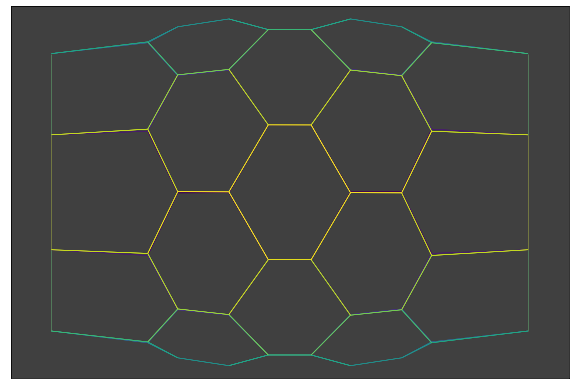

In [4]:
def leg_joint_view(sheet, coords=['z', 'x', 'y']):
    
    geom.update_all(sheet)
    x, y, z = coords
    datasets = {}
    
    datasets['face'] = sheet.face_df.sort_values(z)
    datasets['vert'] = sheet.vert_df.sort_values(z)
    edge_z = 0.5 * (sheet.upcast_srce(sheet.vert_df[z]) +
                    sheet.upcast_trgt(sheet.vert_df[z]))
    datasets['edge'] = sheet.edge_df.copy()
    datasets['edge'][z] = edge_z
    datasets['edge'] = datasets['edge'].sort_values(z)
    
    tmp_sheet = Sheet('tmp', datasets,
                      sheet.specs)
    tmp_sheet.reset_index()

    draw_specs = {
        'vert': {
            'visible': False
            },
        'edge': {
            'color': tmp_sheet.edge_df[z],
            #'zorder': depth.values
            }
        }
    
    fig, ax = sheet_view(tmp_sheet, coords[:2], mode='2D', **draw_specs)
    ax.set_xlim(-15, 15)
    ax.set_ylim(-10, 10)
    ax.set_facecolor('#404040')
    ax.set_xticks([])
    ax.set_yticks([])
    fig.set_size_inches((10, 12))
    return fig, ax

fig, ax = leg_joint_view(sheet)


### Choosing an apoptotic cell 

In [5]:
apoptotic_cell = 16
print('Apoptotic cell position:\n{}'.format(sheet.face_df.loc[apoptotic_cell, sheet.coords]))
apoptotic_edges = sheet.edge_df[sheet.edge_df['face'] == apoptotic_cell]
apoptotic_verts = apoptotic_edges['srce'].values
print("Indices of the apoptotic vertices: {}".format(apoptotic_verts))

Apoptotic cell position:
x   -7.975392
y    3.332710
z   -4.560289
Name: 16, dtype: float64
Indices of the apoptotic vertices: [33 42 34 41 43 44]


Cell behaviours, such as division or apoptosis, are defined as a series of unit changes in the tissue, such as the cell growth, or the abscission of the cell face once division is complete. For a given behavior, the next step often depends on the current state. This is managed by an EventManager object, which runs the behaviour.





In [6]:
from tyssue.behaviors.sheet import apoptosis
from tyssue.behaviors import EventManager


manager = EventManager('face')


sheet.settings['apoptosis'] = {
    'shrink_rate': 1.2,
    'critical_area': 8.,
    'radial_tension': 0.2,
    'contractile_increase': 0.3,
    'contract_span': 2
    }

sheet.face_df['id'] = sheet.face_df.index.values
manager.append(apoptosis, face_id=apoptotic_cell, **sheet.settings['apoptosis'])


Here is the code for the apoptosis behavior:

```py
def apoptosis(sheet, manager, **kwargs):
    """Apoptotic behavior

    While the cell's apical area is bigger than a threshold, the
    cell shrinks, and the contractility of its neighbors is increased.
    once the critical area is reached, the cell is eliminated
    from the apical surface through successive type 1 transition. Once
    only three sides are left, the cell is eliminated from the tissue.

    Parameters
    ----------
    sheet : a :class:`Sheet` object
    manager : a :class:`EventManager` object
    face_id : int,
        the id of the apoptotic cell
    shrink_rate : float, default 0.1
        the rate of reduction of the cell's prefered volume
        e.g. the prefered volume is devided by a factor 1+shrink_rate
    critical_area : area at which the face is eliminated from the sheet
    radial_tension : amount of radial tension added at each contraction steps
    contractile_increase : increase in contractility at the cell neighbors
    contract_span : number of neighbors affected by the contracitity increase
    geom : the geometry class used
    """

    apoptosis_spec = default_apoptosis_spec
    apoptosis_spec.update(**kwargs)
    face = apoptosis_spec["face"]

    if sheet.face_df.loc[face, "area"] > apoptosis_spec["critical_area"]:
        # Shrink and pull
        shrink(sheet, face, apoptosis_spec["shrink_rate"])
        ab_pull(sheet, face, apoptosis_spec["radial_tension"])
        # contract neighbors
        neighbors = sheet.get_neighborhood(
            face, apoptosis_spec["contract_span"]
        ).dropna()
        neighbors["id"] = sheet.face_df.loc[neighbors.face, "id"].values
        manager.extend(
            [
                (
                    contraction,
                    {
                        "face_id": neighbor["id"],
                        "contractile_increase": (
                            apoptosis_spec["contractile_increase"] / neighbor["order"],
                        ),
                    },
                )
                for _, neighbor in neighbors.iterrows()
            ]
        )
        done = False
    else:
        if sheet.face_df.loc[face, "num_sides"] > 3:
            exchange(sheet, face, apoptosis_spec["geom"])
            done = False
        else:
            remove(sheet, face, apoptosis_spec["geom"])
            done = True
    if not done:
        manager.append(apoptosis, **apoptosis_spec)
```


We perform the events at each time points to run the simulation

In [7]:
t = 0
stop=100

progress = widgets.IntProgress(min=0, max=stop)
progress.value = 0
display(progress)

history = History(sheet)

while manager.current and t < stop:
    manager.execute(sheet)
    t += 1
    progress.value = t
    res = solver.find_energy_min(sheet, geom, model, **min_settings)
    history.record()
    manager.update()
        

IntProgress(value=0)

/home/guillaume/miniconda3/envs/tyssue/lib/python3.7/site-packages/tyssue-0.7.0-py3.7-linux-x86_64.egg/tyssue/topology/sheet_topology.py:29: UserWarning: The epsilon argument is deprecated and will be removed in a future version. The length of the new edge should be set by `sheet.settings['threshold_length]*multiplier` 
  "The epsilon argument is deprecated and will be removed in a future version. "
/home/guillaume/miniconda3/envs/tyssue/lib/python3.7/site-packages/tyssue-0.7.0-py3.7-linux-x86_64.egg/tyssue/topology/sheet_topology.py:29: UserWarning: The epsilon argument is deprecated and will be removed in a future version. The length of the new edge should be set by `sheet.settings['threshold_length]*multiplier` 
  "The epsilon argument is deprecated and will be removed in a future version. "
/home/guillaume/miniconda3/envs/tyssue/lib/python3.7/site-packages/tyssue-0.7.0-py3.7-linux-x86_64.egg/tyssue/topology/sheet_topology.py:29: UserWarning: The epsilon argument is deprecated and w

### 3D view with ipyvolume

In [9]:

color = sheet.vert_df['y']
fig, mesh = sheet_view(sheet, coords=['z', 'x', 'y'], edge={"color":color}, mode="3D")
fig

Figure(camera=PerspectiveCamera(aspect=0.8, fov=46.0, matrixWorldNeedsUpdate=True, position=(0.0, 1.2246467991…

Provided you have ImageMagick installed, we can convert the output to a nice gif, like so:

In [10]:
browse_history(history, edge={"color":lambda s : s.edge_df["length"]})

interactive(children=(IntSlider(value=0, description='i', max=17), Output()), _dom_classes=('widget-interact',…

In [13]:
create_gif(
    history,
    'single_apopto.gif',
    num_frames=15,
    draw_func=leg_joint_view
)

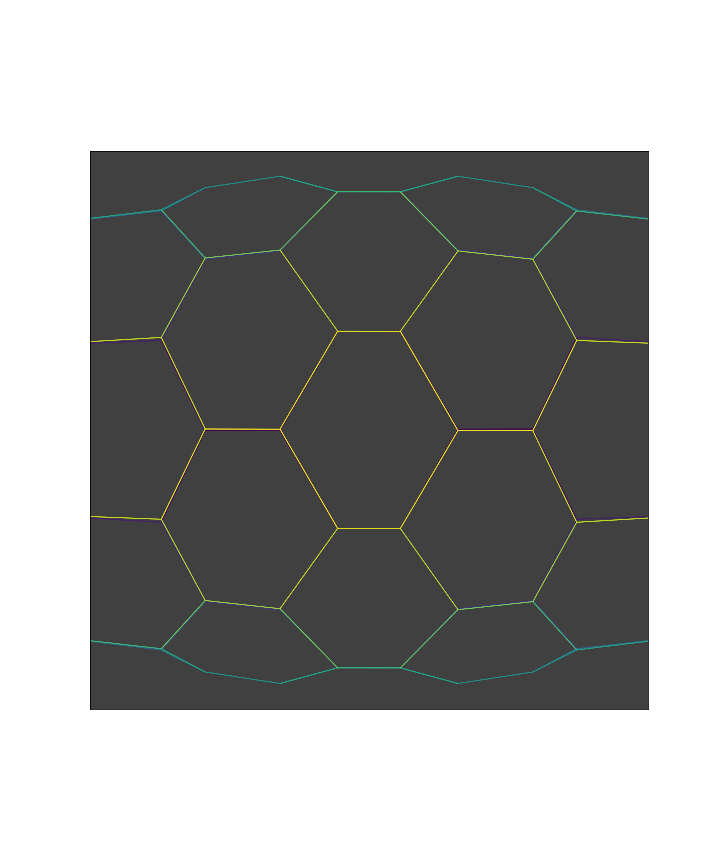

In [14]:
Image("single_apopto.gif")